In [2]:
from langchain_groq import ChatGroq
llm_groq = ChatGroq(model="llama-3.3-70b-versatile")

In [3]:
llm_groq.invoke("Hello, how are you?").content


"Hello. I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you might have. How can I assist you today?"

In [43]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [44]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_groq.invoke(messages)
    return {"messages": [response]}

In [45]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

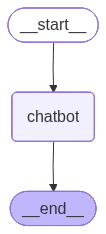

In [46]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [47]:
input={"messages":["hi, my name is Ani"]}

In [48]:
app.invoke(input)

{'messages': [HumanMessage(content='hi, my name is Ani', additional_kwargs={}, response_metadata={}, id='5120ded8-82a5-4993-95d7-4407c8200104'),
  AIMessage(content="Hello Ani! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 42, 'total_tokens': 69, 'completion_time': 0.041639068, 'prompt_time': 0.002441695, 'queue_time': 0.072435115, 'total_time': 0.044080763}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--42d23b16-ce15-4c83-897e-33eb66abf95a-0', usage_metadata={'input_tokens': 42, 'output_tokens': 27, 'total_tokens': 69})]}

In [49]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hello Ani! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 42, 'total_tokens': 69, 'completion_time': 0.044879612, 'prompt_time': 0.002094928, 'queue_time': 0.070618742, 'total_time': 0.04697454}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6103d692-5cc7-4590-8757-63385a4600ef-0', usage_metadata={'input_tokens': 42, 'output_tokens': 27, 'total_tokens': 69})]}




In [50]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [51]:
search.invoke("what is a temprature in sf?")

"It's 60 degrees and foggy."

In [52]:
search.invoke("what is a weather in india?")

"It's 90 degrees and sunny."

In [53]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001FB15227560>)

In [54]:
tools=[search]

In [55]:
tool_node=ToolNode(tools)

In [56]:

llm_with_tool=llm_groq.bind_tools(tools)

In [58]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [59]:
response=call_model({"messages": ["hi how are you?"]})

In [60]:
response

{'messages': [AIMessage(content="I'm doing well, thanks for asking. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 213, 'total_tokens': 238, 'completion_time': 0.063458645, 'prompt_time': 0.037471774, 'queue_time': 0.301225056, 'total_time': 0.100930419}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_55062f05af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9e4b78bf-dbaa-425a-bb3c-7fab935633ca-0', usage_metadata={'input_tokens': 213, 'output_tokens': 25, 'total_tokens': 238})]}

In [62]:
response=call_model({"messages": ["what is a weather in India?"]})

In [63]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'g7cr89mg0', 'function': {'arguments': '{"query":"India weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 215, 'total_tokens': 229, 'completion_time': 0.059032838, 'prompt_time': 0.013628427, 'queue_time': 0.075770253, 'total_time': 0.072661265}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0d777a69-c046-4f4c-83d0-082dc2227262-0', tool_calls=[{'name': 'search', 'args': {'query': 'India weather'}, 'id': 'g7cr89mg0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 215, 'output_tokens': 14, 'total_tokens': 229})]}

In [64]:
messages = response['messages']

In [65]:
last_message=messages[-1]

In [66]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'India weather'},
  'id': 'g7cr89mg0',
  'type': 'tool_call'}]

In [67]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [68]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

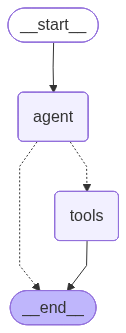

In [69]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [70]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='0b9569f4-4211-40ce-889f-c3a75dad13e2'),
  AIMessage(content="I'm doing well, thanks for asking. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 213, 'total_tokens': 238, 'completion_time': 0.062789027, 'prompt_time': 0.015875223, 'queue_time': 0.064531627, 'total_time': 0.07866425}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--531cd7b2-3b45-4176-aaa1-19a5b5838374-0', usage_metadata={'input_tokens': 213, 'output_tokens': 25, 'total_tokens': 238})]}

In [71]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='3aafe725-863d-4696-9b47-c0acd13a7e91'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fdghk86dm', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 214, 'total_tokens': 229, 'completion_time': 0.055410474, 'prompt_time': 0.013536626, 'queue_time': 0.304128733, 'total_time': 0.0689471}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4d4005649c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--417d2727-eaa8-4e9d-9b95-37008d1a00a2-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': 'fdghk86dm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 15, 'total_tokens': 229}),
  ToolMessage(content="It's 60 degrees and

In [72]:
workflow.add_edge("tools", 'agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [73]:
app = workflow.compile()

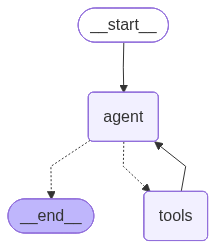

In [74]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [75]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rbjtaytkc', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 214, 'total_tokens': 229, 'completion_time': 0.064445355, 'prompt_time': 0.012426024, 'queue_time': 0.053934885, 'total_time': 0.076871379}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7031f8e8-7e8f-461e-bd22-b81a333c1102-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': 'rbjtaytkc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 15, 'total_tokens': 229})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='826f2a73-81b6-4098-bd00-c2

#Memory saver

In [76]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [77]:
# Define a new graph
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

In [78]:
app3 = workflow3.compile(checkpointer = memory)

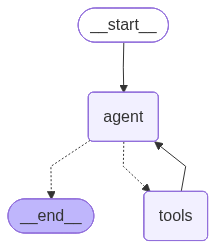

In [79]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [80]:
config = {"configurable": {"thread_id": "1"}}

In [81]:
events = app3.stream(
    {"messages": ["Hi there! My name is Sunny."]}, config, stream_mode="values"
)

In [82]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Sunny.
================================== Ai Message ==================================

It's nice to meet you, Sunny. Is there something I can help you with or would you like to chat?


In [83]:
events = app3.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

In [84]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
================================== Ai Message ==================================

Your name is Sunny.


In [86]:
memory.get(config)

{'v': 4,
 'ts': '2025-10-23T15:22:40.564990+00:00',
 'id': '1f0b0241-d511-65ed-8004-aa0b91c3f619',
 'channel_versions': {'__start__': '00000000000000000000000000000005.0.00913623832625865',
  'messages': '00000000000000000000000000000006.0.022978737625881873',
  'branch:to:agent': '00000000000000000000000000000006.0.022978737625881873'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000004.0.08881680739861064'},
  'agent': {'branch:to:agent': '00000000000000000000000000000005.0.00913623832625865'}},
 'updated_channels': ['messages'],
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Sunny.', additional_kwargs={}, response_metadata={}, id='518d2e48-d307-4d9e-9e2e-1133488fc0d3'),
   AIMessage(content="It's nice to meet you, Sunny. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 216, 'total_tokens': 2